<a href="https://colab.research.google.com/github/DataSEARCH-UOM/cricket_analytics/blob/master/scripts/capture_pradeep_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Requirements :
Change the runtime to GPU for faster execution with cuDF

** Skip the cudf conf, not working properly yet **

In [0]:
#!wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
#!chmod +x Miniconda3-4.8.3-Linux-x86_64.sh
#!bash ./Miniconda3-4.8.3-Linux-x86_64.sh -b -f -p /usr/local

In [2]:
# Check python version is 3.6 for cuDF parrallel processing
!python -V; pip -V

Python 3.6.9
pip 19.3.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)


In [3]:
# Check Cuda version is > 9 for cuDF parrallel processing , note to change the cuda version in cuDF installation
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
# Check GPU architecture >= Pascal arch  , positives : teslap100-PCIE
!nvidia-smi 

Mon May 11 05:58:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 103 (delta 21), reused 14 (delta 1), pack-reused 0
Receiving objects: 100% (103/103), 30.32 KiB | 7.58 MiB/s, done.
Resolving deltas: 100% (21/21), done.
PLEASE READ
********************************************************************************************************
Changes:
1. Now that most people have migrated, we have rem0ved the migration notice.
2. default stable version is now 0.13.  Nightly is now 0.14
3. You can now declare your RAPIDS version as a CLI option and skip the user prompts (ex: '0.13' or '0.14', between 0.11 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/

In [11]:
# Getting the data
!wget https://github.com/DataSEARCH-UOM/cricket_analytics/raw/master/data/Gyro_XYZ_WIMU_11_06th_March_2018.7z
!mkdir -p data/Exported_Parameter_Data
!mv Gyro_XYZ_WIMU_11_06th_March_2018.7z data/Exported_Parameter_Data
!sudo apt-get install p7zip
!7za e data/Exported_Parameter_Data/Gyro_XYZ_WIMU_11_06th_March_2018.7z -odata/Exported_Parameter_Data/

--2020-05-11 07:00:03--  https://github.com/DataSEARCH-UOM/cricket_analytics/raw/master/data/Gyro_XYZ_WIMU_11_06th_March_2018.7z
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DataSEARCH-UOM/cricket_analytics/master/data/Gyro_XYZ_WIMU_11_06th_March_2018.7z [following]
--2020-05-11 07:00:04--  https://raw.githubusercontent.com/DataSEARCH-UOM/cricket_analytics/master/data/Gyro_XYZ_WIMU_11_06th_March_2018.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14730927 (14M) [application/octet-stream]
Saving to: ‘Gyro_XYZ_WIMU_11_06th_March_2018.7z’

Gyro_XYZ_WIMU_11_06 100%[===================>]  14.05

In [0]:
import pandas as pd
import numpy as np
# import cudf
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None                              # to get away from the huge warning list on the copy
import chardet

In [0]:
with open('data/Exported_Parameter_Data/Gyro_XYZ_WIMU_11_06th_March_2018.csv', 'rb') as f:
    result = chardet.detect(f.readline())  # or readline if the file is large
result
df=pd.read_csv('data/Exported_Parameter_Data/Gyro_XYZ_WIMU_11_06th_March_2018.csv',sep='\t',encoding='utf-16')
df=df.rename(columns=lambda x: x.strip())  #Remove trailing whitespaces
df.TIME = pd.to_datetime(df.TIME, format='%H:%M:%S %f')
df.TIME = df.TIME.astype('int64')//-1000000
df['WIMU_11  GYRO X(degs/s)'] = df['WIMU_11  GYRO X(degs/s)'].str.replace(',','.').astype('float64')
df['WIMU_11  GYRO Y(degs/s)'] = df['WIMU_11  GYRO Y(degs/s)'].str.replace(',','.').astype('float64')
df['WIMU_11  GYRO Z(degs/s)'] = df['WIMU_11  GYRO Z(degs/s)'].str.replace(',','.').astype('float64')
df.rename(columns={'TIME':'time','WIMU_11  GYRO X(degs/s)':'gyro_x','WIMU_11  GYRO Y(degs/s)':'gyro_y','WIMU_11  GYRO Z(degs/s)':'gyro_z'},inplace=True)

In [5]:
df.head()

,time,gyro_x,gyro_y,gyro_z,SELECT,BANDS
0,2208942238641,0.026747,-0.394802,0.528371,NaN,NaN
1,2208942238631,-0.018961,-0.496490,0.482662,NaN,NaN
2,2208942238621,0.026809,-0.587969,0.467364,NaN,NaN
3,2208942238611,0.092843,-0.598147,0.513135,NaN,NaN
4,2208942238601,-0.034197,-0.770958,0.518193,NaN,NaN


In [0]:
# import os  
# os.environ['NUMBAPRO_NVVM']='/usr/local/cuda-10.1/nvvm/lib64/libnvvm.so'
# os.environ['NUMBAPRO_LIBDEVICE']='/usr/local/cuda-10.1/nvvm/libdevice'

# cu_df = cudf.DataFrame.from_pandas(df)

In [6]:
df.head()

,time,gyro_x,gyro_y,gyro_z,SELECT,BANDS
0,2208942238641,0.026747,-0.394802,0.528371,NaN,NaN
1,2208942238631,-0.018961,-0.496490,0.482662,NaN,NaN
2,2208942238621,0.026809,-0.587969,0.467364,NaN,NaN
3,2208942238611,0.092843,-0.598147,0.513135,NaN,NaN
4,2208942238601,-0.034197,-0.770958,0.518193,NaN,NaN


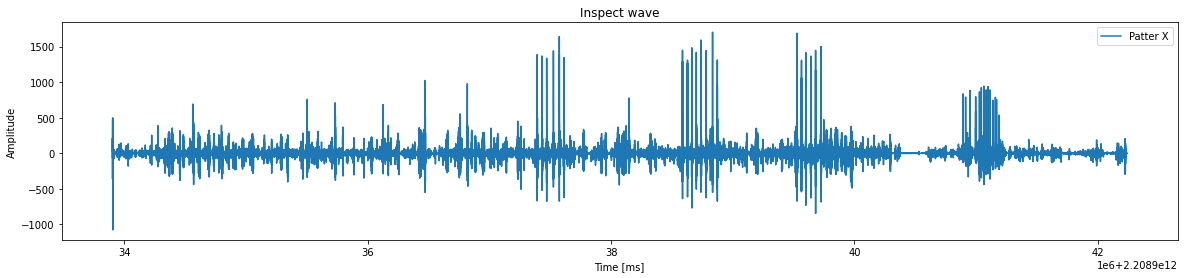

In [7]:
# keeping dfS in pandas for plotting

dfS = df
fig = plt.figure(figsize=[20,4])
plt.ylabel("Amplitude")
plt.xlabel("Time [ms]")
plt.plot(dfS['time'], dfS['gyro_x'],label="Patter X")

plt.legend()
plt.title('Inspect wave')
plt.show()

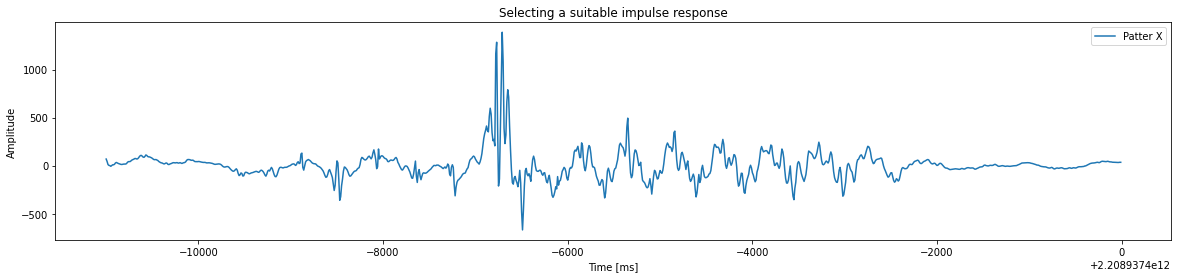

In [8]:
# Selecting pulse
start=2.208937e12
dfP = dfS.loc[(dfS['time']>start+389000) & (dfS['time']<start+400000)]
fig = plt.figure(figsize=[20,4])
plt.ylabel("Amplitude")
plt.xlabel("Time [ms]")
plt.plot(dfP['time'], dfP['gyro_x'],label="Patter X")

plt.legend()
plt.title('Selecting a suitable impulse response')
plt.show()

In [9]:
dfP.head()

,time,gyro_x,gyro_y,gyro_z,SELECT,BANDS
483865,2208937399991,34.449760,-9.921861,15.968203,NaN,NaN
483866,2208937399981,34.780365,-10.704831,15.205682,NaN,NaN
483867,2208937399971,33.031403,-12.453698,13.827911,NaN,NaN
483868,2208937399961,32.619560,-13.999283,11.941826,NaN,NaN
483869,2208937399951,33.565228,-15.066774,9.171082,NaN,NaN


In [0]:
def findPatterns(dfS,dfP,threshold,axis_name,time_name):
    from scipy import signal
    from scipy.signal import argrelextrema

    n=len(dfP)
    pd.options.mode.chained_assignment = None                              # to get away from the huge warning list on the copy
    filtered_col = 'convolved_'+axis_name
    filtered_max_col = 'convolved_'+axis_name+'_max'
    filtered_thres_col= 'convolved_'+axis_name+'_threshold'
    start_pulse_col = 'start_pulse_'+axis_name
    end_pulse_col = 'end_pulse_'+axis_name
    # df['min'] = df.iloc[argrelextrema(df.data.values, np.less_equal, order=n)[0]]['data']
    dfS[filtered_col]=signal.convolve(dfS[axis_name], dfP[axis_name], mode='same') / (sum(dfP[axis_name]))
    dfS[filtered_max_col] = dfS.iloc[argrelextrema(dfS[filtered_col].values, np.greater_equal, order=n)[0]][filtered_col]
    dfS[filtered_thres_col]=dfS[filtered_max_col].copy(deep=True)
    dfS[filtered_thres_col].loc[dfS[filtered_thres_col]<threshold] =np.NaN

    pulse_width=np.abs(dfP.iloc[-1][time_name]-dfP.iloc[0][time_name])

    middlePoints=dfS[dfS[filtered_thres_col].notnull()]
    dfS[start_pulse_col]=np.NaN
    dfS[end_pulse_col]=np.NaN
    pulse_count = 1
    for index,row in middlePoints.iterrows():
        start_time = int(np.abs(row[time_name] - pulse_width//2))
        end_time = row[time_name] + pulse_width//2
        dfS.at[dfS.loc[(dfS[time_name]>start_time) & (dfS[time_name]<start_time+10)].index,start_pulse_col] = pulse_count
        dfS.at[dfS.loc[(dfS[time_name]>end_time)&(dfS[time_name]<end_time+10)].index,end_pulse_col] = pulse_count
        pulse_count+=1

    fig = plt.figure(figsize=[20,4])
    plt.ylabel("Amplitude")
    plt.xlabel("Time [ms]")
    plt.plot(dfS[time_name], dfS[axis_name],label="signal "+axis_name)
    # plt.plot(dfS['time'], dfS['filtered_orig'],label="Filtered")
    for index,row in dfS[dfS[start_pulse_col].notnull()].iterrows():
        plt.axvline(x=row[time_name],color='k')
    for index,row in dfS[dfS[end_pulse_col].notnull()].iterrows():
        plt.axvline(x=row[time_name],color='k')

    plt.scatter(dfS[time_name], dfS[filtered_thres_col],label="Middle Pulse", color='r')
    plt.plot(dfS[time_name], dfS[filtered_col],label="Convolved signal "+axis_name)
    plt.legend()
    plt.show()
    
    return dfS

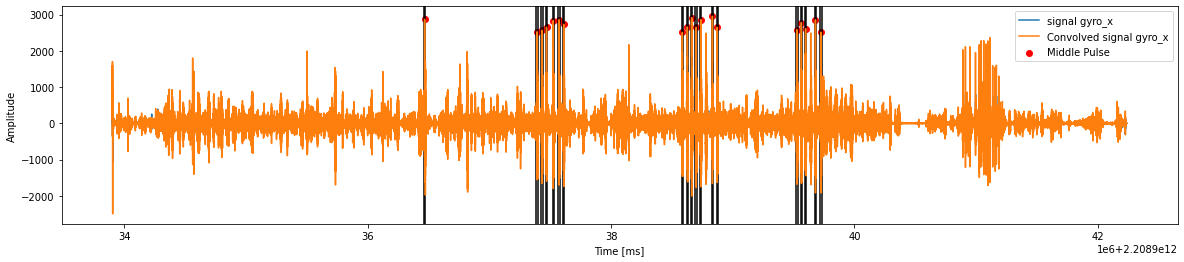

In [11]:
reusult = findPatterns(dfS,dfP,2500,'gyro_x','time')

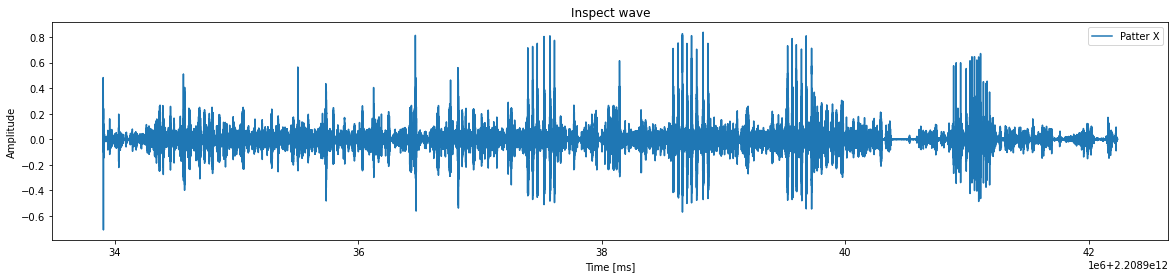

In [12]:
# Unit normalizing the output
fig = plt.figure(figsize=[20,4])
plt.ylabel("Amplitude")
plt.xlabel("Time [ms]")
plt.plot(dfS['time'], dfS['convolved_gyro_x']/sum(dfP['gyro_x']),label="Patter X")        # With this second devision, it has now divided by the square of the pattern

plt.legend()
plt.title('Inspect wave')
plt.show()

In [0]:
def test(x):
  print(x-dfP['gyro_x'])
  eucl=np.linalg.norm(x-dfP['gyro_x'])    
  print(eucl)
  return eucl 

In [16]:
# using parallel cuDF
dfS = df
# dfP=cudf.DataFrame.from_pandas(dfP)
eculid_dist=dfS['gyro_x'].rolling(len(dfP['gyro_x'])).apply(test)

Streaming output truncated to the last 5000 lines.
484960   NaN
484961   NaN
484962   NaN
484963   NaN
484964   NaN
Length: 2200, dtype: float64
nan
1850     NaN
1851     NaN
1852     NaN
1853     NaN
1854     NaN
          ..
484960   NaN
484961   NaN
484962   NaN
484963   NaN
484964   NaN
Length: 2200, dtype: float64
nan
1851     NaN
1852     NaN
1853     NaN
1854     NaN
1855     NaN
          ..
484960   NaN
484961   NaN
484962   NaN
484963   NaN
484964   NaN
Length: 2200, dtype: float64
nan
1852     NaN
1853     NaN
1854     NaN
1855     NaN
1856     NaN
          ..
484960   NaN
484961   NaN
484962   NaN
484963   NaN
484964   NaN
Length: 2200, dtype: float64
nan
1853     NaN
1854     NaN
1855     NaN
1856     NaN
1857     NaN
          ..
484960   NaN
484961   NaN
484962   NaN
484963   NaN
484964   NaN
Length: 2200, dtype: float64
nan
1854     NaN
1855     NaN
1856     NaN
1857     NaN
1858     NaN
          ..
484960   NaN
484961   NaN
484962   NaN
484963   NaN
484964   NaN
Leng

KeyboardInterrupt: ignored

In [0]:
dfS = df
fig = plt.figure(figsize=[20,4])
plt.ylabel("Amplitude")
plt.xlabel("Time [ms]")
plt.plot(dfS['time'], eculid_dist,label="Patter X")       

plt.legend()
plt.title('Inspect wave')
plt.show()

In [13]:
dfP['gyro_x']-x

NameError: ignored

In [6]:
!pip freeze | grep cudf

cudf==0.13.0
dask-cudf==0.13.0
